# Explore data

Simple notebook to explore the dataset

In [1]:
# mandatory stuff to get things working properly
import os
import json
import psutil
p = psutil.Process()
p.cpu_affinity([0])
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import utils
from gwpy.table import EventTable

import jax.numpy as jnp
from ripple import ms_to_Mc_eta, Mc_eta_to_ms

rcparams = {"axes.grid": True,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}

plt.rcParams.update(rcparams)

ModuleNotFoundError: No module named 'jax'

## Load in the selected detected events:

In [2]:
data_dir = "./data_split/"
bns_o5 = data_dir + "bns_O5HL_injections.dat"
data_dict = utils.read_injections_file(bns_o5)

my_outdir = "./injections_tidal/outdir/" # where the rundirs will come

Sanity checking the code:

In [3]:
for key, value in data_dict.items():
    print(f"{key}: examples values {value[:5]}")
    
example_event_id = int(data_dict["simulation_id"][0])

simulation_id: examples values [ 9 14 21 23 24]
longitude: examples values [3.7971859  4.5625499  0.96535827 3.3950243  2.4084685 ]
latitude: examples values [ 0.87535684 -0.00339247  1.405876   -0.33706707  0.0869114 ]
inclination: examples values [0.38678959 0.32873468 2.6485628  2.3010108  0.26154381]
distance: examples values [203.77752 636.56451 226.54627 487.65838 443.7946 ]
mass1: examples values [2.0644817 1.9580471 2.1042908 2.1821147 2.0891864]
mass2: examples values [1.6678797 1.4436337 1.7786805 1.9537788 1.3713884]
spin1z: examples values [-0.06107824 -0.0595872  -0.09220774 -0.14975753  0.07147652]
spin2z: examples values [-0.0003123  -0.01736595  0.10383004 -0.05204631 -0.05826461]
polarization: examples values [1.33792651 6.27256107 5.72252846 3.25340319 1.80338764]
coa_phase: examples values [-2.08128214 -2.9611845   0.80135041  0.14345084 -2.74263024]
geocent_end_time: examples values [1.02630596e+09 1.02778482e+09 1.02535090e+09 1.02246412e+09
 1.02606043e+09]
geocen

## Need the SNR

The SNR is not in this file, but it is in the following file. NOTE: this dataset is stored on the LIGO LDAS CIT cluster, but it is the same as on the LHO cluster as computed by Weizmann at `/home/weizmann.kiendrebeogo/Andrew/HL-SNR-10/runs/`.

In [4]:
# Use the EventTable to read the XML file
xml_filename = "/home/thibeau.wouters/gw-datasets/H0_inference_O5/events_O5.xml" # on CIT!
table = EventTable.read(xml_filename, tablename = "coinc_inspiral")

# Get the keys of this table
keys = table.keys()
print("keys")
print(keys)

# Get some specific variables that I want to use
simulation_id_xml = np.array(table["coinc_event_id"])
snr_xml = np.array(table["snr"])
end_time = np.array(table["end_time"])

# Show the SNR of the above example
idx = np.where(simulation_id_xml == example_event_id)[0][0]
snr_example = snr_xml[idx]
end_time_example = end_time[idx]

print("snr_example")
print(snr_example)

print("end_time_example")
print(end_time_example)

keys
['coinc_event_id', 'combined_far', 'end_time', 'end_time_ns', 'false_alarm_rate', 'ifos', 'mass', 'mchirp', 'minimum_duration', 'snr']
snr_example
20.71345431810761
end_time_example
1026305955


This seems to be working fine, now let us put into a complete function

In [5]:
snr_array, ifos_array = utils.get_events_info(table, data_dict["simulation_id"])

print("Examples of SNR and ifos:")
print(snr_array[:5])
print(ifos_array[:5])

data_dict["snr"] = snr_array
data_dict["ifos"] = ifos_array
assert len(data_dict["ifos"]) == len(data_dict["simulation_id"]), "ifos and simulation_id have different lengths"

Examples of SNR and ifos:
[20.71345432 11.58412296 31.55944294 10.75187143 10.835764  ]
['H1,L1', 'H1,L1', 'H1,L1', 'H1,L1', 'H1,L1']


## Choosing the BNS events to tackle

Take those with highest SNR, or randomly sample? What are the SNRs if we just take the top 50 ones?

In [6]:
# Sort SNR values from high to low, make sure to sort the idx list at the same time
sorted_snr_idx = np.argsort(snr_array)[::-1]
sorted_snr = snr_array[sorted_snr_idx]
sorted_simulation_idx = data_dict["simulation_id"][sorted_snr_idx]

print("sorted_snr, first 50")
print(sorted_snr[:50])

sorted_snr, first 50
[63.47535619 59.65775812 55.42929873 50.72056796 48.6138467  44.61218785
 44.0660772  43.3813171  42.57851225 41.41300996 39.6358033  38.80703057
 38.62244252 36.54715672 35.57436289 34.4796026  34.30099831 34.28965473
 33.74905411 32.59052893 32.55596111 32.2977602  32.16810916 31.55944294
 31.44207786 31.03362048 30.39608731 30.3711357  29.88166661 29.58638693
 29.28157827 29.20367065 27.82695018 27.2917565  26.93201092 26.7481318
 26.40765504 26.11700296 26.09528608 25.68047288 25.4508018  25.18723955
 24.92625627 24.91675985 24.90273178 24.76511285 24.76201261 24.36011021
 23.67123411 23.29264891]


Randomly sample 50 events

In [7]:
nb_events = 50
sampled_indices = np.random.choice(len(data_dict["simulation_id"]), nb_events, replace = False)

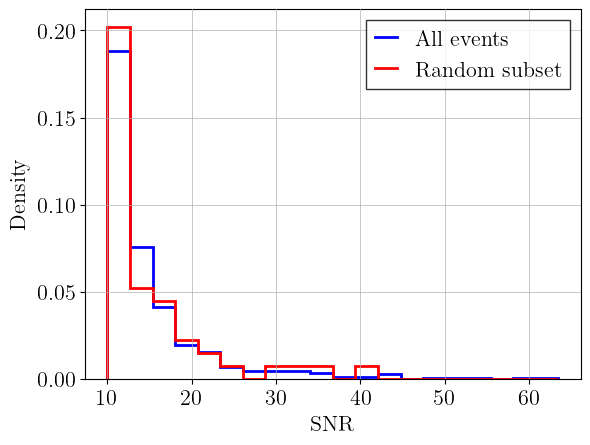

In [8]:
# Show the SNR of the sampled events
sampled_snr = snr_array[sampled_indices]

hist, bins = np.histogram(snr_array, bins = 20, density=True)
hist_sampled, _ = np.histogram(sampled_snr, bins = bins, density=True)
plt.stairs(hist, bins, fill = False, color = "blue", linewidth = 2, label = "All events")
plt.stairs(hist_sampled, bins, fill = False, color = "red", linewidth = 2, label = "Random subset")
plt.xlabel("SNR")
plt.ylabel("Density")
plt.legend()
plt.show()

## Testing generation of config files for the injections

In [9]:
print("Original dictionary length")
print(len(data_dict["simulation_id"]))

filtered_dict = utils.filter_dict_by_indices(data_dict, sampled_indices)

print("New dictionary length")
print(len(filtered_dict["simulation_id"]))

Original dictionary length
549
New dictionary length
50


Take an extreme case of a single entry to be saved:

In [10]:
separate_dicts = utils.split_dict(data_dict)

In [13]:
# Select dicts that have spins between -0.05 and 0.05
MTOV_threshold = 2.25
passes_criterion = lambda x: (x["mass1"] < MTOV_threshold) * (x["mass2"] < MTOV_threshold) * (abs(x["spin1z"]) < 0.05) * (abs(x["spin2z"]) < 0.05)
selected_dicts = [d for d in separate_dicts if passes_criterion(d)]
print(f"Number of low spin: {len(selected_dicts)}")
print(selected_dicts[0]) # an example:

Number of low spin: 36
{'simulation_id': 81, 'longitude': 5.3942362, 'latitude': -0.75930781, 'inclination': 1.1613845, 'distance': 121.54648, 'mass1': 2.1086698, 'mass2': 1.526639, 'spin1z': -0.042715258, 'spin2z': -0.024932431, 'polarization': 0.05012752115726471, 'coa_phase': 2.753676652908325, 'geocent_end_time': 1019348129.0, 'geocent_end_time_ns': 454129219.0, 'redshift': 0.026883157335461722, 'source_mass1': 2.0534661465005803, 'source_mass2': 1.486672547986176, 'snr': 44.61218785183569, 'ifos': 'H1,L1'}


## Spins are large? Investigation

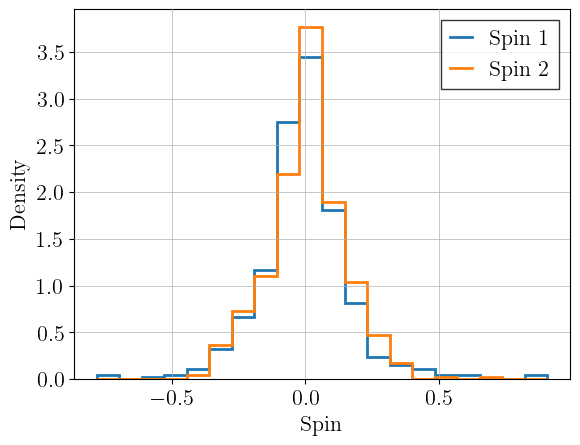

In [14]:
s1z = data_dict["spin1z"]
s2z = data_dict["spin2z"]
simulation_id_list = data_dict["simulation_id"]

hist_1, bins = np.histogram(s1z, bins = 20, density=True)
hist_2, _ = np.histogram(s2z, bins = bins, density=True)

for hist, label in zip([hist_1, hist_2], ["Spin 1", "Spin 2"]):
    plt.stairs(hist, bins, fill = False, linewidth = 2, label = label)
plt.legend()
plt.xlabel("Spin")
plt.ylabel("Density")
plt.show()

Selected dicts:

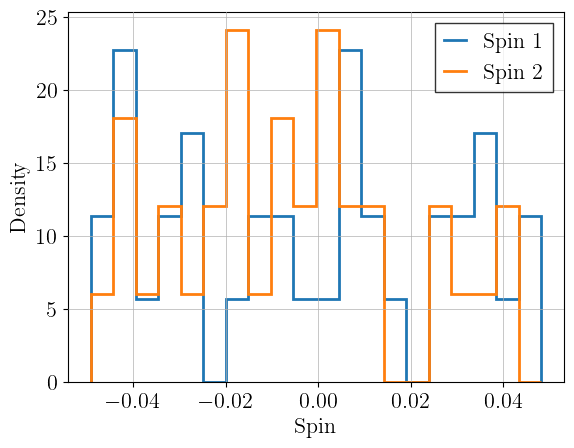

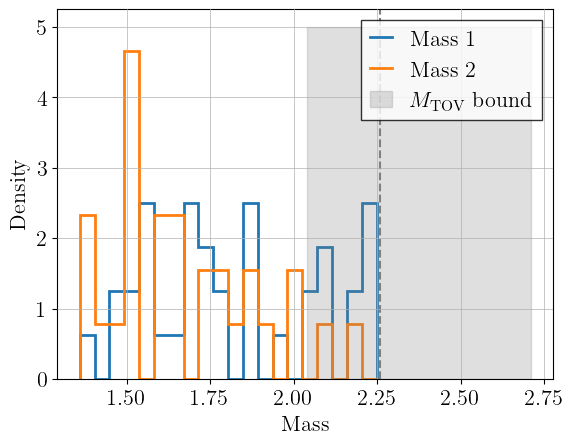

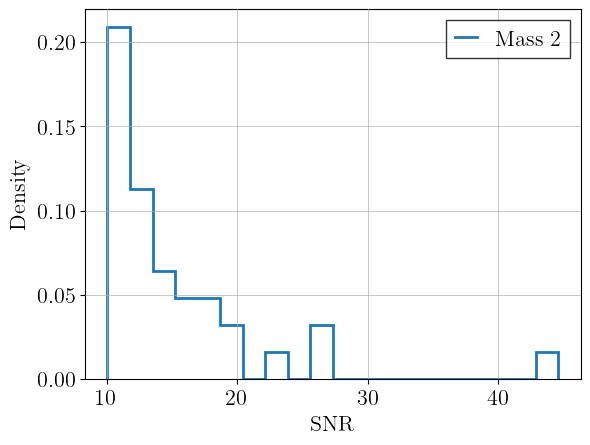

In [15]:
def get_values_by_key(list_of_dicts: list[dict], key: str):
    return np.array([d[key] for d in list_of_dicts])

spin1z = get_values_by_key(selected_dicts, "spin1z")
spin2z = get_values_by_key(selected_dicts, "spin2z")
mass1 = get_values_by_key(selected_dicts, "mass1")
mass2 = get_values_by_key(selected_dicts, "mass2")
snr = get_values_by_key(selected_dicts, "snr")

hist_1, bins = np.histogram(spin1z, bins = 20, density=True)
hist_2, _ = np.histogram(spin2z, bins = bins, density=True)

for hist, label in zip([hist_1, hist_2], ["Spin 1", "Spin 2"]):
    plt.stairs(hist, bins, fill = False, linewidth = 2, label = label)
plt.legend()
plt.xlabel("Spin")
plt.ylabel("Density")
plt.show()

hist_1, bins = np.histogram(mass1, bins = 20, density=True)
hist_2, _ = np.histogram(mass2, bins = bins, density=True)
for hist, label in zip([hist_1, hist_2], ["Mass 1", "Mass 2"]):
    plt.stairs(hist, bins, fill = False, linewidth = 2, label = label)
# Show the bands from Hauke's paper: https://arxiv.org/abs/2402.04172
middle = 2.26
xmin = middle - 0.22
xmax = middle + 0.45
ymin = 0
ymax = 5
plt.fill_between([xmin, xmax], ymin, ymax, color = "gray", alpha = 0.25, label = r"$M_{\rm{TOV}}$ bound")
plt.axvline(middle, ymin=ymin, ymax=ymax, color = "gray", linestyle = "--")
plt.xlabel("Mass")
plt.ylabel("Density")
plt.legend()
plt.show()


hist, bins = np.histogram(snr, bins = 20, density=True)
plt.stairs(hist, bins, fill = False, linewidth = 2, label = label)
plt.legend()
plt.xlabel("SNR")
plt.ylabel("Density")
plt.show()

## Get the final config files (low spin only)

Commented out for now since I don't need to create them anymore.

In [16]:
# for config_dict in selected_dicts:
#     _ = utils.generate_config(config_dict, "./injections_tidal/outdir/")

In [54]:
# simulation_id = get_values_by_key(selected_dicts, "simulation_id")
# simulation_id

array([  81,  143,  187,  399,  404,  419,  532,  541,  737,  795,  868,
       1017, 1032, 1064, 1247, 1316, 1572, 1654, 1920, 2097, 2335, 2786,
       2810, 2949, 3267, 3554, 3875, 3904, 3912, 3938, 4019, 4139, 4397,
       4543, 4627, 4748])

# Analyze the selected events:

In [34]:
subdirs = os.listdir(my_outdir)
dL_list = [] 
spin1_list = []
spin2_list = []
snr_list = []

for subdir in subdirs:
    if not os.path.isdir(my_outdir + subdir):
        continue
        
    # Load the config and save dL, chi1, chi2
    with open(my_outdir + subdir + "/config.json", "r") as f:
        config = json.load(f)
        
        dL, chi1, chi2, snr = config["d_L"], config["s1_z"], config["s2_z"], config["snr"]
        dL_list.append(dL)
        spin1_list.append(chi1)
        spin2_list.append(chi2)
        snr_list.append(snr)
        
        # Hacky way
        if snr > 40:
            print(f"High SNR: {snr}, subdir: {subdir}")

High SNR: 55.42929873301911, subdir: injection_129
High SNR: 59.65775811995256, subdir: injection_238


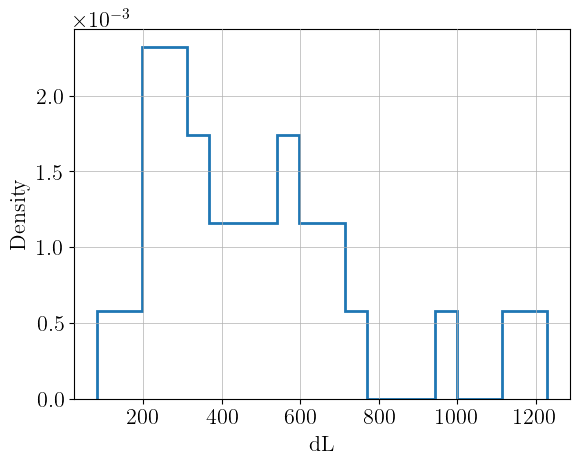

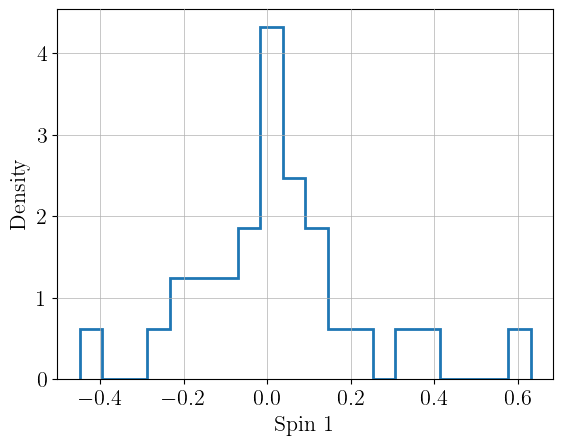

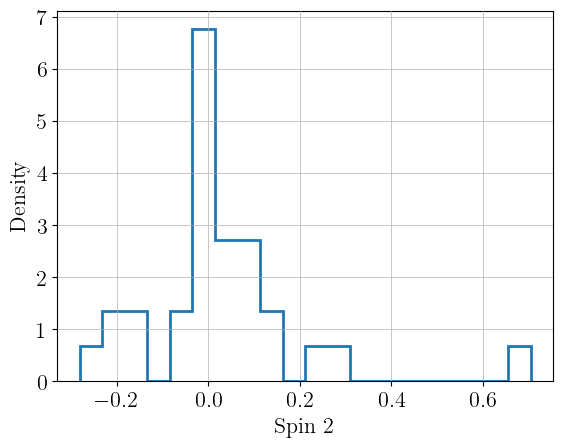

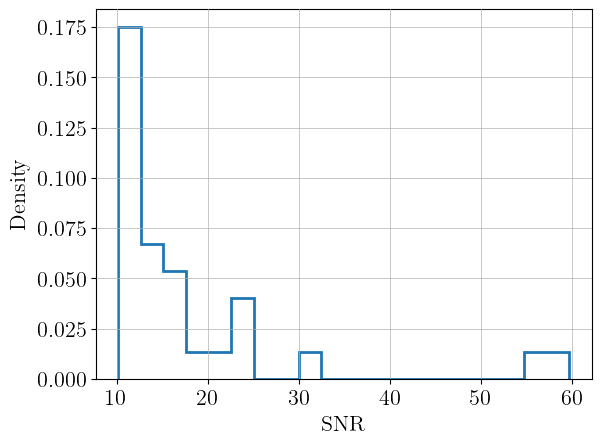

In [35]:
# Make histograms

for values, label in zip([dL_list, spin1_list, spin2_list, snr_list], ["dL", "Spin 1", "Spin 2", "SNR"]):
    hist, bins = np.histogram(values, bins = 20, density = True)
    plt.stairs(hist, bins, fill = False, linewidth = 2)
    plt.xlabel(label)
    plt.ylabel("Density")
    plt.show()

Check the masses

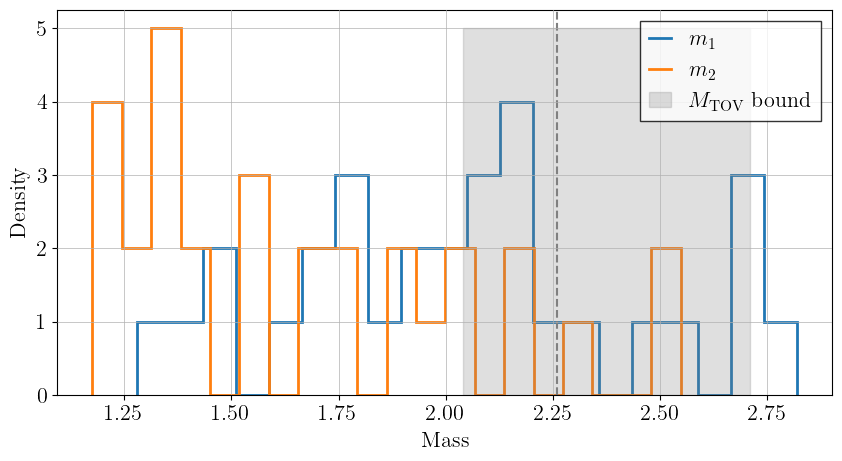

In [36]:
m1_list = []
m2_list = []

for subdir in subdirs:
    if not os.path.isdir(my_outdir + subdir):
        continue
        
    # Load the config and save dL, chi1, chi2
    with open(my_outdir + subdir + "/config.json", "r") as f:
        config = json.load(f)
        
        mc, q = config["M_c"], config["q"]
        eta = q / (1 + q)**2
        m1, m2 = Mc_eta_to_ms(jnp.array([mc, eta]))
        
        m1_list.append(m1)
        m2_list.append(m2)
        
# Make histograms
plt.figure(figsize = (10, 5))
for values, label in zip([m1_list, m2_list], [r"$m_1$", r"$m_2$"]):
    hist, bins = np.histogram(values, bins = 20)
    plt.stairs(hist, bins, fill = False, linewidth = 2, label = label)

# Finalize plot
plt.xlabel("Mass")
plt.ylabel("Density")
# Show the bands from Hauke's paper: https://arxiv.org/abs/2402.04172
middle = 2.26
xmin = middle - 0.22
xmax = middle + 0.45
ymin = 0
ymax = 5
plt.fill_between([xmin, xmax], ymin, ymax, color = "gray", alpha = 0.25, label = r"$M_{\rm{TOV}}$ bound")
plt.axvline(middle, ymin=ymin, ymax=ymax, color = "gray", linestyle = "--")
plt.legend()
plt.show()

# Archive

Old way to get the desired low spin

In [ ]:
# # Count how many events have a spins 1 and 2 between -0.05 and 0.05
# low_spin_indices = []
# MAX_NB = 30 # max number of runs to save

# nb_events_low_spin = 0
# for (sim_id, s1, s2) in enumerate(zip(simulation_id_list, s1z, s2z)):
#     if -0.05 < s1 < 0.05 and -0.05 < s2 < 0.05:
#         nb_events_low_spin += 1
#         low_spin_indices.append(sim_id)
        
# print(f"Number of events with spins between -0.05 and 0.05: {nb_events_low_spin}")

# print("low_spin_indices")
# print(low_spin_indices)

# test_idx = low_spin_indices[2]
# print(test_idx)
# print(data_dict["spin1z"][test_idx])
# print(data_dict["spin2z"][test_idx])

# # Show their SNR, sorted from high to low
# snr_low_spin = snr_array[low_spin_indices]
# sorted_snr_low_spin_idx = np.argsort(snr_low_spin)[::-1]
# sorted_snr_low_spin = snr_low_spin[sorted_snr_low_spin_idx]
# sorted_simulation_low_spin_idx = data_dict["simulation_id"][low_spin_indices][sorted_snr_low_spin_idx]

# # Save the highest SNR up to MAX_NB
# nb_to_save = min(MAX_NB, len(sorted_snr_low_spin))
# print(f"Saving {nb_to_save} highest SNR events")
# for i in range(nb_to_save):
#     idx = sorted_snr_low_spin_idx[i]
#     print(f"Saving event {idx}")
#     filtered_dict = utils.filter_dict_by_indices(data_dict, [idx])
#     utils.generate_config(filtered_dict, my_outdir)

# print("sorted_snr_low_spin")
# print(sorted_snr_low_spin)

# # Show the first simulation ID with highest SNR
# print("sorted_simulation_low_spin_idx highest SNR")
# print(low_spin_indices[sorted_snr_low_spin_idx[0]])

Number of events with spins between -0.05 and 0.05: 73
low_spin_indices
[10, 14, 25, 27, 32, 46, 47, 50, 60, 61, 65, 83, 86, 87, 102, 103, 108, 113, 114, 116, 117, 125, 136, 139, 140, 162, 169, 170, 180, 184, 194, 196, 197, 200, 208, 212, 213, 221, 228, 242, 259, 264, 266, 276, 291, 296, 298, 308, 314, 321, 328, 346, 354, 363, 391, 394, 409, 416, 423, 429, 430, 432, 441, 443, 458, 463, 465, 488, 500, 505, 524, 541, 547]
25
-0.0017102223
0.024478602
Saving 30 highest SNR events
Saving event 46
Made injection directory:  ./injections_tidal/outdir/injection_258/
Injection directory exists:  ./injections_tidal/outdir/injection_258/
Saving event 1
Made injection directory:  ./injections_tidal/outdir/injection_14/
Injection directory exists:  ./injections_tidal/outdir/injection_14/
Saving event 43
Made injection directory:  ./injections_tidal/outdir/injection_240/
Injection directory exists:  ./injections_tidal/outdir/injection_240/
Saving event 41
Made injection directory:  ./injections_tid

## What priors should I use?

In [ ]:
m1 = data_dict["source_mass1"]
m2 = data_dict["source_mass2"]
print(f"m1 varies between {np.min(m1)} and {np.max(m1)}")
print(f"m2 varies between {np.min(m2)} and {np.max(m2)}\n")

# Compute the chirp mass for this
mc, _ = ms_to_Mc_eta(jnp.array([m1, m2]))
print(f"mc varies between {np.min(mc)} and {np.max(mc)}")

m1 varies between 1.165401132017992 and 2.9580925863349057
m2 varies between 1.0775479143315756 and 2.7747819657642503

mc varies between 1.00662100315094 and 2.44429349899292
